In [131]:
import numpy as np
import cupy as cp
import dxchange
import matplotlib.pyplot as plt
import xraylib

from holotomo.holo import G
from holotomo.magnification import M
from holotomo.shift import S
from holotomo.tomo import R

%matplotlib inline

cp.cuda.Device(0).use()
np.random.seed(1)

# Init data sizes and parametes of the PXM of ID16A

In [132]:
n = 256  # object size in each dimension
ntheta = 180  # number of angles (rotations)

center = n/2  # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles


npos = 1  # number of code positions 

detector_pixelsize = 3e-6*0.7
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = 4.584e-3-sx0#np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:npos]-sx0
z1 = np.tile(z1,[npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = 8e-3  # positions of the code and the probe for reconstruction

z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16*0
# sample size after demagnification
ne = n+2*pad
print(distances+distances2)
print(1/norm_magnifications)
print(norm_magnifications2)

[0.00220585 0.00220585 0.00220585 0.00220585]
[1. 1. 1. 1.]
[0.27746556 0.27746556 0.27746556 0.27746556]


## Read real and imaginary parts of the refractive index u = delta+i beta

2.071661502345279e-07 9.634532228012238e-11 2150.246066251103
2.9839802972997376e-07 3.224279760663861e-10 925.4718941278695
1.395387139169202e-10 4.686360040313982e-15 29775.5001144921
1.8644953514446172e-07 8.671079005211015e-11 2150.246065482878
2.071661502345279e-07 9.634532228012238e-11 2150.246066251103


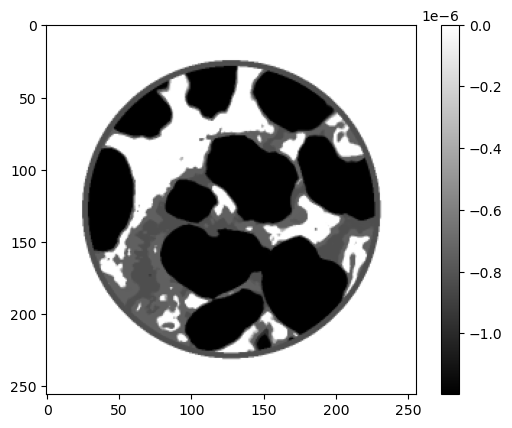

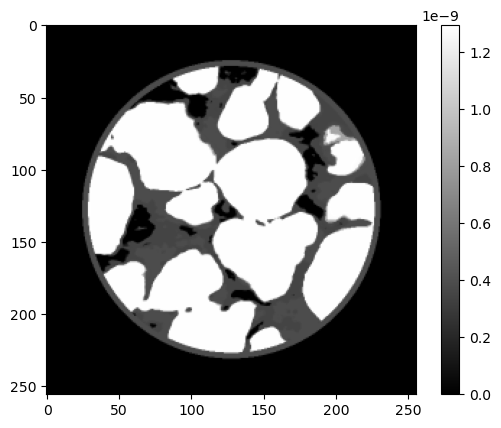

In [133]:
ut = dxchange.read_tiff('data/part512x512x512.tif').copy()
[x,y,z] = np.meshgrid(np.arange(-256,256)/256,np.arange(-256,256)/256,np.arange(-256,256)/256)
circ = x**2+y**2+z**2<0.6
[x,y] = np.meshgrid(np.arange(-256,256)/256,np.arange(-256,256)/256)
# circ *= x**2+y**2<0.5
ut*=circ

[x,y,z] = np.meshgrid(np.arange(-256,256)/256,np.arange(-256,256)/256,np.arange(-256,256)/256)
circ = x**2+y**2+z**2<0.65
[x,y] = np.meshgrid(np.arange(-256,256)/256,np.arange(-256,256)/256)
# circ *= x**2+y**2<0.55

# ut[:64]=0
# ut[-64:]=0

u = np.zeros([512,512,512],dtype='complex64')
# circ = x**2+y**2<0.53
delta = 1-xraylib.Refractive_Index_Re('H2O',energy,1)
beta = xraylib.Refractive_Index_Im('H2O',energy,1)
u[circ] = delta+1j*beta
print(delta,beta,delta/beta)


# u[:60]=0
# u[-60:]=0
#1
delta = 1-xraylib.Refractive_Index_Re('SiO2',energy,1.6)
beta = xraylib.Refractive_Index_Im('SiO2',energy,1.6)
print(delta,beta,delta/beta)
u[ut==1] = delta+1j*beta

#2
delta = 1-xraylib.Refractive_Index_Re('CH4',energy,0.0006)
beta = xraylib.Refractive_Index_Im('CH4',energy,0.00006)
print(delta,beta,delta/beta)
u[ut==2] = delta+1j*beta

#34
delta = 1-xraylib.Refractive_Index_Re('H2O',energy,0.9)
beta = xraylib.Refractive_Index_Im('H2O',energy,0.9)
print(delta,beta,delta/beta)
u[ut==3] = delta+1j*beta
u[ut==4] = delta+1j*beta

#5
delta = 1-xraylib.Refractive_Index_Re('H2O',energy,1)
beta = xraylib.Refractive_Index_Im('H2O',energy,1)
print(delta,beta,delta/beta)
u[ut==5] = delta+1j*beta

# plt.imshow(u[256].real,cmap='gray')
# plt.colorbar()
# plt.show()
# plt.imshow(u[:,256].imag,cmap='gray')
# plt.colorbar()
# plt.show()

u = u[::2]+u[1::2]
u = u[:,::2]+u[:,1::2]
u = u[:,:,::2]+u[:,:,1::2]
u/=2

v = np.arange(-n//2,n//2)/n
[vx,vy,vz] = np.meshgrid(v,v,v)
v = np.exp(-0.5*(vx**2+vy**2+vz**2))
fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(u)))
u = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v))).astype('complex64')

u[np.where(u.real<0)] = 0
u = -u.real+1j*u.imag
u = u.astype('complex64')#.get()
plt.imshow(u[128].real,cmap='gray')
plt.colorbar()
plt.show()
plt.imshow(u[:,128].imag,cmap='gray')
plt.colorbar()
plt.show()

## Compute tomographic projection data via the Fourier based method, $\mathcal{R}u$:

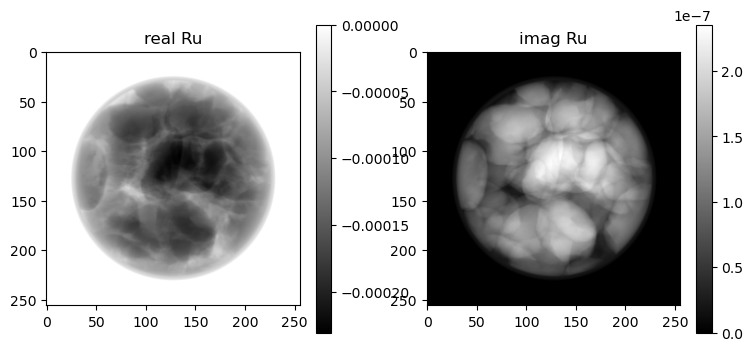

In [134]:
Ru = R(u, theta, center*ne/n)
Ru = Ru.swapaxes(0, 1)
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im = axs[0].imshow(np.real(Ru[0]), cmap='gray')
axs[0].set_title('real Ru')
fig.colorbar(im)
im = axs[1].imshow(np.imag(Ru[0]), cmap='gray')
axs[1].set_title('imag Ru')
fig.colorbar(im)

## Convert it to the transmittance function $e^{\frac{2\pi j}{\lambda} \mathcal{R} u }$

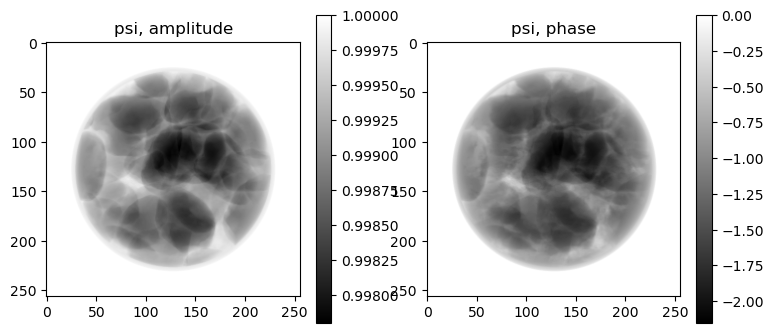

In [135]:
psi = np.exp(2*np.pi*1j/wavelength*voxelsize*Ru)
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psi[0]),cmap='gray')
axs[0].set_title('psi, amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi[0]),cmap='gray')
axs[1].set_title('psi, phase')
fig.colorbar(im)

## Use prb==1

In [136]:
prb = np.ones([1,n+2*pad,n+2*pad],dtype='complex64')

### Generate a coded aperture, make it twice bigger than the sample to allow motion

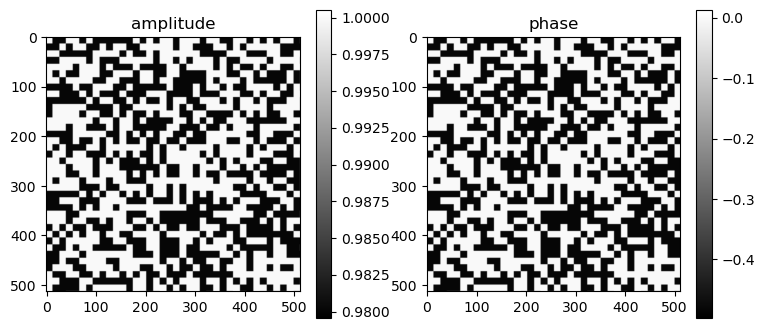

In [137]:
import random
import xraylib
import scipy.ndimage as ndimage

code_thickness = 1e-6 #in m
ill_feature_size = 0.7e-6 #in m

random.seed(10)
nill = 2*ne
ill_global = np.zeros([1,nill,nill],dtype='bool')
for k in  range(ill_global.shape[0]):
    ill0 = np.zeros([nill*nill],dtype='bool')
    ill_ids = random.sample(range(0, nill*nill), nill*nill//2)
    ill0[ill_ids] = 1
    ill_global[k] = ill0.reshape(nill,nill)

# form codes for simulations

nill = int(ne*voxelsize/magnifications2[0]//(ill_feature_size*2))*2
ill = np.zeros([1,nill,nill],dtype='bool')
for k in  range(ill.shape[0]):
    ill0 = ill_global[k]
    ill[k] = ill0[ill0.shape[0]//2-nill//2:ill0.shape[0]//2+(nill)//2,ill0.shape[1]//2-nill//2:ill0.shape[1]//2+(nill)//2]#.reshape(nill,nill)
    
ill = ndimage.zoom(ill,[1,2*ne/nill,2*ne/nill],order=0,grid_mode=True,mode='grid-wrap')

delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)

thickness = code_thickness/voxelsize # thickness in pixels

v = np.arange(-2*ne//2,2*ne//2)/2/ne
[vx,vy] = np.meshgrid(v,v)
v = np.exp(-5*(vx**2+vy**2))
fill = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(ill)))
ill = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fill*v)))
ill = ill.astype('complex64')


# form Transmittance function
Rill = ill*(-delta+1j*beta)*thickness 
code = np.exp(1j * Rill * voxelsize * 2 * np.pi / wavelength).astype('complex64')

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(code[0]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(code[0]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)

### Shifts/drifts

In [138]:
# shifts of codes
shifts_code = np.round((np.random.random([ntheta, npos, 2]).astype('float32')-0.5)*ne/4)
# shifts of codes for reference images
shifts_code0 = np.round((np.random.random([1, npos, 2]).astype('float32')-0.5)*ne/4)
# use the first ref image as the global reference for code
shifts_code0[0, 0, :] = 0

np.save('data/shifts_code', shifts_code)
np.save('data/shifts_code0', shifts_code0)

### Compute holographic projections for all angles and all distances
#### $d=\left|\mathcal{G}_{z}(\mathcal{G}_{z'}(q\mathcal{S}_{s_{j}}c)\psi)\right|_2^2$, and reference data $d^r=\left|\mathcal{G}_{z+z'}(q(\mathcal{S}_{s_{j}'}c))\right|$

In [139]:
from holotomo.chunking import gpu_batch

@gpu_batch
def _fwd_holo(psi, shifts_code, code, prb):
    prb = cp.array(prb)
    code = cp.array(code)
    
    data = cp.zeros([psi.shape[0],npos,n,n],dtype='complex64')
    for i in range(npos):        
        # ill shift for each acquisition
        prbr = cp.tile(prb,[psi.shape[0],1,1])
        # code shift for each acquisition        
        coder = cp.tile(code,[psi.shape[0],1,1])
        coder = S(coder, shifts_code[:,i])    
        
        coder = coder[:,ne-n//2-pad:ne+n//2+pad,ne-n//2-pad:ne+n//2+pad]
        
        # multiply the code and ill
        prbr *= coder        
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[i])
        
        psir = psi.copy()
                
        # multiply the ill and object
        psir *= prbr

        # propagate both
        psir = G(psir, wavelength, voxelsize, distances[i])   
        data[:,i] = psir[:,pad:n+pad,pad:n+pad]
    return data

def fwd_holo(psi, prb):
    return _fwd_holo(psi, shifts_code, code, prb) 

@gpu_batch
def _fwd_holo0(prb,code):    
    data = cp.zeros([1,npos, n, n], dtype='complex64')
    for j in range(npos):        
        # ill shift for each acquisition
        prbr = prb.copy()
        coder = S(code, shifts_code0[:,j])            
        coder = coder[:,ne-n//2-pad:ne+n//2+pad,ne-n//2-pad:ne+n//2+pad]
        prbr*=coder
        # propagate illumination 
        data[:,j]=G(prbr, wavelength, voxelsize, distances[0])[:,pad:n+pad,pad:n+pad]        
    return data

def fwd_holo0(prb): 
    return _fwd_holo0(prb, code)

fpsi = fwd_holo(psi,prb)
fref = fwd_holo0(prb)

### Take squared absolute value to simulate data on the detector and a reference image

In [140]:
data = np.abs(fpsi)**2
ref = np.abs(fref)**2

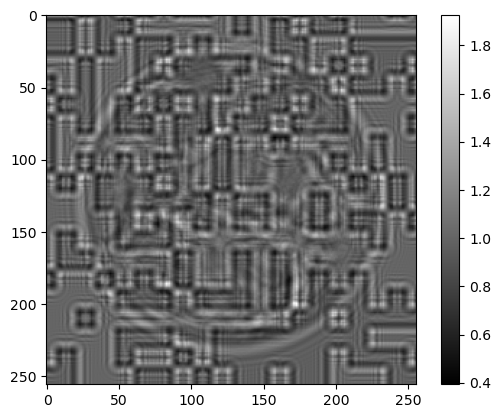

In [141]:
plt.imshow(data[0,0],cmap='gray')
plt.colorbar()


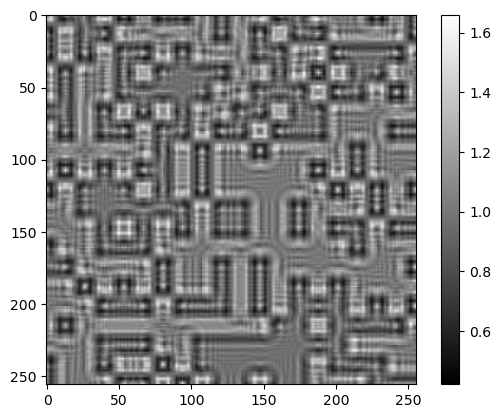

In [142]:
plt.imshow(ref[0,0],cmap='gray')
plt.colorbar()


# Save data, reference images, and shifts

In [143]:
for k in range(npos):
    dxchange.write_tiff(data[:,k],f'data/data_{n}_{k}',overwrite=True)
for k in range(npos):
    dxchange.write_tiff(ref[:,k],f'data/ref_{n}_{k}',overwrite=True)
dxchange.write_tiff(psi,f'data/psi_{n}',overwrite=True)
dxchange.write_tiff(u,f'data/u_{n}',overwrite=True)
np.save('data/code',code)
